Class Distribution: Counter({2: 742, 0: 278, 1: 1})


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


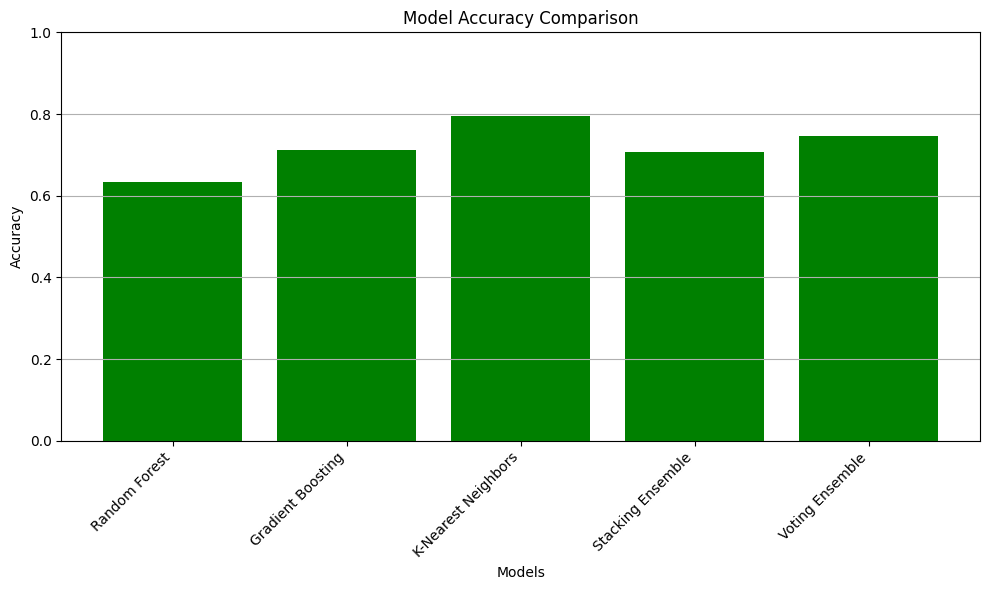

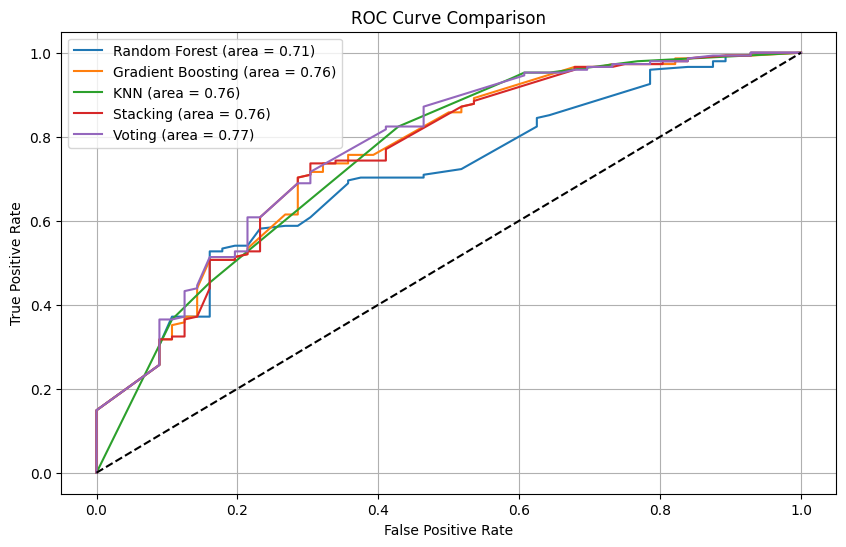

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.77      0.53        56
           2       0.87      0.58      0.70       148

    accuracy                           0.63       204
   macro avg       0.64      0.67      0.62       204
weighted avg       0.74      0.63      0.65       204



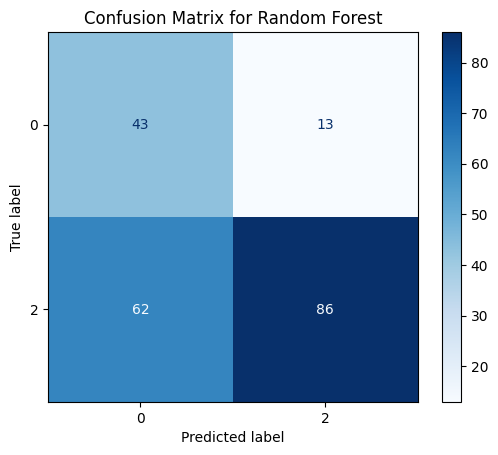

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.70      0.57        56
           2       0.86      0.72      0.78       148

    accuracy                           0.71       204
   macro avg       0.67      0.71      0.68       204
weighted avg       0.76      0.71      0.72       204



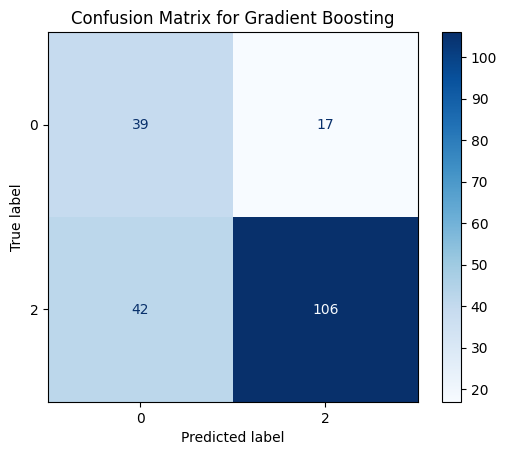

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.41      0.52        56
           2       0.81      0.94      0.87       148

    accuracy                           0.79       204
   macro avg       0.76      0.67      0.70       204
weighted avg       0.78      0.79      0.77       204



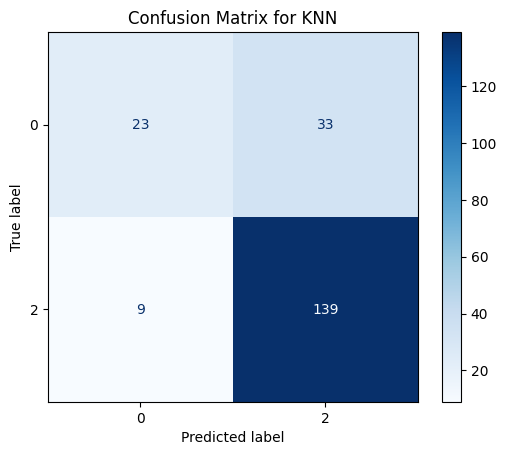

Stacking Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.70      0.57        56
           2       0.86      0.71      0.78       148

    accuracy                           0.71       204
   macro avg       0.67      0.70      0.67       204
weighted avg       0.75      0.71      0.72       204



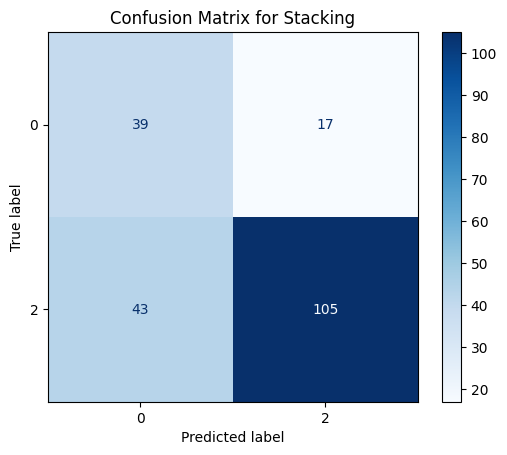

Voting Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        56
           2       0.82      0.82      0.82       148

    accuracy                           0.75       204
   macro avg       0.68      0.68      0.68       204
weighted avg       0.75      0.75      0.75       204



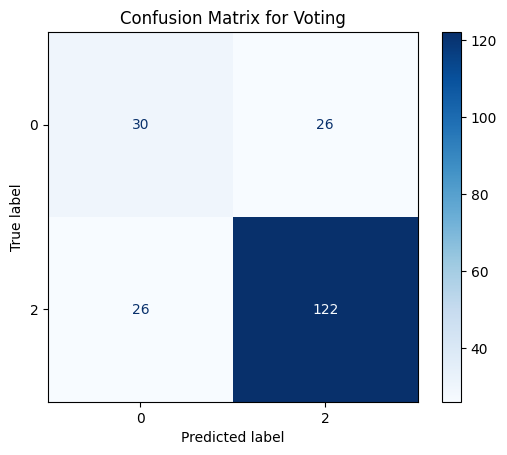

In [ ]:
# ENSEMBLE STACKING VS VOTING CLASSIFIER
# 01
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              StackingClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder
from sklearn.impute import SimpleImputer  # Import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from collections import Counter
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling

# Load the data
data = pd.read_excel("/content/COLOR COMBINATION DATASET_FEATURE SELECTION OUTCOMES.xlsx")
X = data.drop(['Combination','BACKGROUND'], axis=1)  # Drop Combination and Background columns
y = data['BACKGROUND']  # Target variable

# Convert string labels to numerical using Label Encoding
le = LabelEncoder()
y = le.fit_transform(y)

# Convert string features to numerical using Label Encoding
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = le.fit_transform(X[column])

# 03 # Split the data into training and testing sets (using StratifiedKFold for class imbalance)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Check class distribution before splitting
print("Class Distribution:", Counter(y))

# Remove classes with only 1 sample
valid_indices = [i for i, val in enumerate(y) if list(y).count(val) > 1]
X = X.iloc[valid_indices]
y = y[valid_indices]

# Now you can perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# 04 # Initialize base models with aggressive regularization and adjusted parameters
rf = RandomForestClassifier(random_state=42,
                            n_estimators=30,  # Reduced number of trees
                            max_depth=3,  # Reduced max_depth
                            min_samples_split=20,  # Increased min_samples_split
                            min_samples_leaf=10,  # Increased min_samples_leaf
                            max_features='sqrt',  # Using sqrt for feature selection
                            bootstrap=True)  # Enable bootstrapping
gbm = GradientBoostingClassifier(random_state=42,
                                 max_depth=2,  # Reduced max_depth
                                 learning_rate=0.05,  # Decreased learning rate
                                 n_estimators=150,  # Increased n_estimators slightly
                                 subsample=0.8)  # Introduce subsampling
knn = KNeighborsClassifier(n_neighbors=7)  # Increased n_neighbors


# 05 # Train each model
rf.fit(X_train, y_train)
gbm.fit(X_train, y_train)
knn.fit(X_train, y_train)

# 06 # Get predictions for the test set
rf_pred = rf.predict(X_test)
gbm_pred = gbm.predict(X_test)
knn_pred = knn.predict(X_test)

# Use the best models from GridSearchCV for stacking and voting
# (If you're not using GridSearchCV, you can skip this step)
# best_rf = rf.best_estimator_
# best_gbm = gbm.best_estimator_

# 06 # Get predictions for the test set
rf_pred = rf.predict(X_test)
gbm_pred = gbm.predict(X_test)
knn_pred = knn.predict(X_test)

# 05 # Stacking Classifier (consider early stopping for GBM in final_estimator)
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf),  # Use the trained rf model directly
        ('gbm', gbm)  # Use the trained gbm model directly
    ],
    final_estimator=LogisticRegression()
)
stacking_model.fit(X_train, y_train)  # Fit the stacking model
y_pred_stacking = stacking_model.predict(X_test)

# 07 # Voting Classifier
voting_model = VotingClassifier(estimators=[
    ('rf', rf),
    ('gbm', gbm),
    ('knn', knn)
], voting='soft')
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

# 08 # Calculate accuracy
accuracies = {
    'Random Forest': accuracy_score(y_test, rf_pred),
    'Gradient Boosting': accuracy_score(y_test, gbm_pred),
    'K-Nearest Neighbors': accuracy_score(y_test, knn_pred),
    'Stacking Ensemble': accuracy_score(y_test, y_pred_stacking),
    'Voting Ensemble': accuracy_score(y_test, y_pred_voting)
}

# 08 # Plotting Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='green')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# 09 # Optional: ROC Curve (for binary classification)
if len(np.unique(y)) == 2: # Check if binary classification
 plt.figure(figsize=(10, 6))

 for model, preds in zip(['Random Forest', 'Gradient Boosting', 'KNN', 'Stacking', 'Voting'],
 [rf.predict_proba(X_test)[:, 1],
 gbm.predict_proba(X_test)[:, 1],
 knn.predict_proba(X_test)[:, 1],
 stacking_model.predict_proba(X_test)[:, 1],
 voting_model.predict_proba(X_test)[:, 1]]):

   # Specify pos_label for roc_curve
   fpr, tpr, _ = roc_curve(y_test, preds, pos_label=2) # Assuming '2' is the positive class label
   roc_auc = auc(fpr, tpr)
   plt.plot(fpr, tpr, label=f'{model} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# 10
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Print classification report for each model
for model_name, y_pred in zip(['Random Forest', 'Gradient Boosting', 'KNN', 'Stacking', 'Voting'],
 [rf_pred, gbm_pred, knn_pred, y_pred_stacking, y_pred_voting]):
 print(f"{model_name} Classification Report:")
 print(classification_report(y_test, y_pred))
 # Confusion Matrix
 cm = confusion_matrix(y_test, y_pred)
 # Get unique labels from y_test and y_pred
 labels = np.unique(np.concatenate((y_test, y_pred)))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=labels) # Use unique labels from y_test and y_pred
 disp.plot(cmap=plt.cm.Blues)
 plt.title(f'Confusion Matrix for {model_name}')
 plt.show()




In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from joblib import dump
from collections import Counter # Import the Counter class
from google.colab import files  # For downloading the file (only in Colab)

# Load the data
data = pd.read_excel("/content/COLOR COMBINATION DATASET_FEATURE SELECTION OUTCOMES.xlsx")

# Keep the 'Combination' column and use 'BACKGROUND' as the target variable (numeric: 0 for dark, 1 for light)
X = data.drop(['Combination'], axis=1)  # Use 'Combination' and other columns as features
y = data['BACKGROUND']  # Target variable (already numeric: 0 for dark, 1 for light)

# Convert string features to numerical using Label Encoding
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = pd.factorize(X[column])[0]  # Factorize strings to integers

# Handle missing values (if any) in the dataset
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Check class distribution before SMOTE
print("Class Distribution Before SMOTE:", Counter(y))

# Apply SMOTE for class balancing, adjusting k_neighbors if needed
# Check if the minority class has more than 1 sample before applying SMOTE
minority_class_samples = Counter(y).most_common()[-1][1]
if minority_class_samples > 1:
    k_neighbors = min(5, minority_class_samples - 1)  # Adjust k_neighbors here
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X, y = smote.fit_resample(X, y)
else:
    print("Minority class has only 1 sample. Skipping SMOTE.")
    # Remove the samples corresponding to the minority class with 1 sample
    X = X[y != Counter(y).most_common()[-1][0]]
    y = y[y != Counter(y).most_common()[-1][0]]

# Check class distribution after SMOTE
print("Class Distribution After SMOTE:", Counter(y))

# Initialize models for the Voting Classifier
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()

# Initialize the Voting Classifier
voting_classifier = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('rf', model3)], voting='soft')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the Voting Classifier
voting_classifier.fit(X_train, y_train)

# Save the trained Voting Classifier model
dump(voting_classifier, 'voting_classifier.pkl')

# Download the trained Voting Classifier model file
files.download('voting_classifier.pkl')

print("Voting Classifier model saved and ready for download.")


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Class Distribution Before SMOTE: Counter({'Light': 742, 'Dark': 278, 'Ligh': 1})
Minority class has only 1 sample. Skipping SMOTE.
Class Distribution After SMOTE: Counter({'Light': 742, 'Dark': 278})


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Voting Classifier model saved and ready for download.
